## Description

When the Major League Baseball playoffs come around every October, predictions and bets about which team will win the World Series intensify. While there are always differing opinions, the unbiased consensus regarding the favorite is almost always the team with the highest regular season win total. However, this prediction is usually wrong - the winningest regular season team has only won the World Series 4 times in the last 30 seasons (excludes the 1994 season that had no World Series due to a players strike). Further, a 2022 Elder Research study found that teams' perceived skill levels ("power ratings") correctly predicted ~56% of regular season winners in simulations but only ~31% of World Series winners. This 25% discrepancy is the largest of the 4 major professional sports organizations in America (MLB, National Football League, National Basketball Association, National Hockey League), and means having such a long regular season (162 games) does not necessarily translate to more predictable World Series winners.

This raises some questions regarding World Series predictions:
- Why is regular season wins such a poor predictor of World Series champion? Is it primarily due to level of randomness in team performances in each individual game, the format of the playoffs, or other factors?
- What metrics - whether they be certain team statistics, individual player statistics, injuries, payrolls, fan bases, stadiums, etc. - have a material impact on playoff performance and World Series winners?
- Can we determine metrics that are greater predictors of World Series winners than regular season wins? Can we build a model that predicts these metrics for future seasons and uses these projections to predict future World Series winners?

[Elder Research Report](https://www.elderresearch.com/blog/how-often-does-the-best-team-win-the-title/#:~:text=The%20MLB's%20best%20team%2C%20on,the%20best%20regular%20season%20team)

## Data Source

For this project, I will be web scraping from BaseballReference.com, which is the most extensive public, free online database for MLB data and statistics. It is a highly tableted website, as most pages of statistics are presented nicely in tables. I will clean the data by using the HTML code for the website's various pages to pull stat tables, and then will use the data cleaning methods we have learned in class to transform these tables into clean Pandas dataframes. See an example at the bottom of this file of a cleaned table for a player's (Carlos Correa) lifetime MLB stats. Compared with the screenshot of Correa's BaseballReference.com page at the bottom of this cell, you can see the tables are nearly identical. While each player page has several tables, this one is the most useful, as it shows the most commonly known stats, which for position players include games played, at bats, hits, batting average, home runs, and slugging percentage. I've inspected the HTML code for team stat tables on team pages and the tag structure is nearly identical, so the code I have already written below can be easily adjusted to clean team data build dataframes for any team stats. The team pages have tables on rosters, cumulative team statistics from previous seasons, player contract details, and more [Baseball Reference home page](https://www.baseball-reference.com/).

I am highly confident in my data's reliability since BaseballReference.com is a reputable source.
One issue I expect to encounter is program speed as Professor Gerber has informed me that BaseballReference.com limits web scraping to 20 requests per minute. For example, just running an analysis of the stats of each player on a single team may take over 1 minute, which could slow down my investigative process.
Another issue I foresee is if I look at team rosters each season, I will need to write code that accounts for midseason trades, players being called up from or sent down to the Minor Leagues, and other roster adjustments during a season.

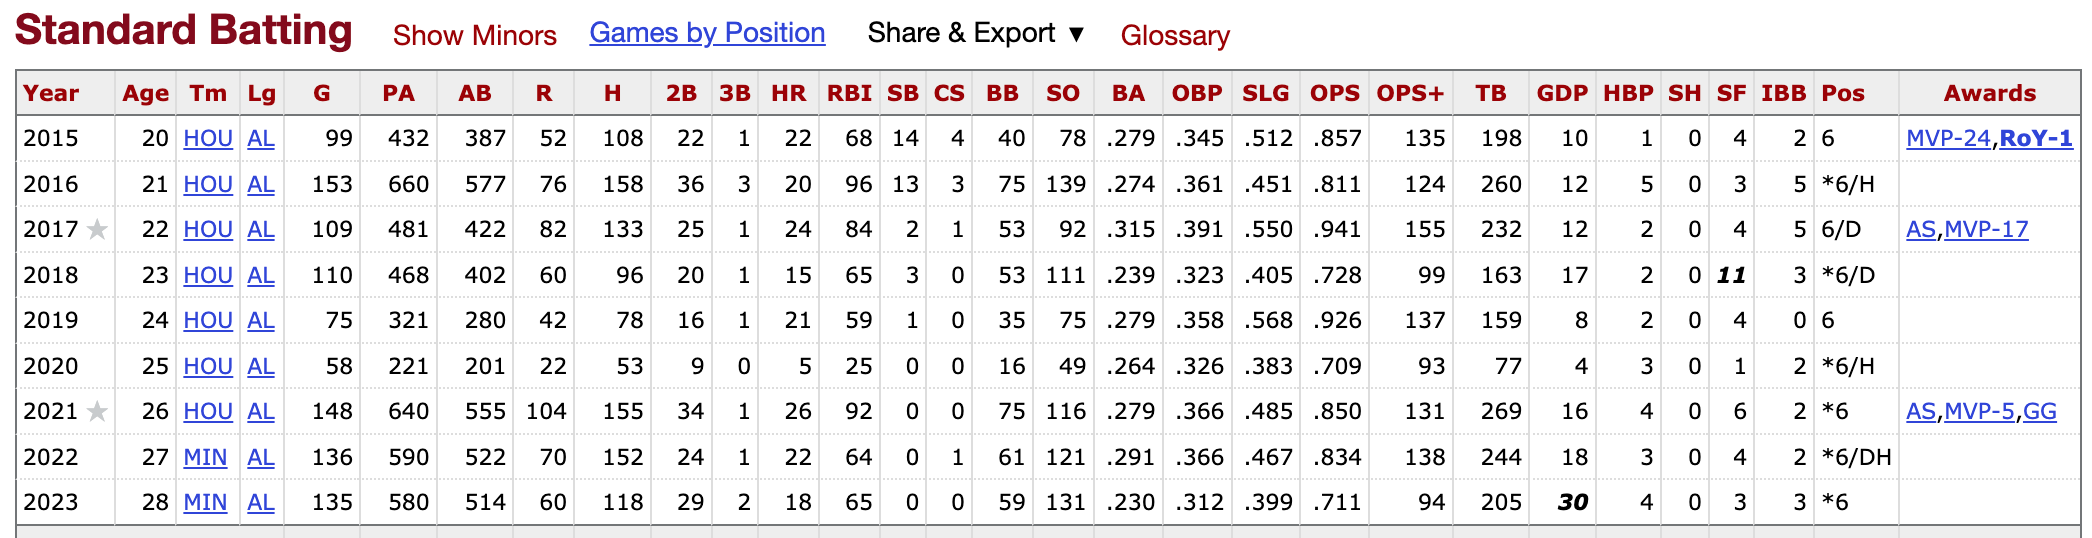

## Usage of Data

After cleaning and visualizing the data, I will used the data to try to answer the questions posed above. Although we have only just begun covering machine learning models in class, I have prior experience with some ML methods and see a few paths for learning and predicting on this data.
- I might begin by running several random forests, each on different groups of statistics (i.e., single season team statistics, single season player statistics for the top players on teams' rosters, etc.) to see which metrics, if any, appear to have a noticeable correlation with World Series winners and playoff performance. I could also run similar ML models to see which factors influence regular season performance the most, and compare these findings.
- After determining which factors might be more correlated with playoff performance and regular season performance, I could run linear regressions on regular season performance versus playoff performance. Then, I would turn this into a multiple regression model and perform trial and error by introducing various additional factors into the model.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
def build_player_url(player):
    """ Constructs the URL of any MLB player's Baseball Reference stat page
    
    Args:
        player (str): a baseball player's full name
    
    Returns:
        url (str): the URL that can be used to retrieve the given player's
        stats from BaseballReference.com
    """
    first_init = player[0]
    first_two_letters = player[0:2]
    player_name_list = player.split(' ')
    # get last name except for last letter. Gets position 1 instead of -1 in case of a Jr./Sr. or II/III
    last_name = player_name_list[1][:-1]
    
    url = f"https://www.baseball-reference.com/players/{first_init}/{last_name}{first_two_letters}01.shtml"
    
    return url

In [3]:
player = 'carlos correa'
url = build_player_url(player)

In [4]:
def get_player_soup(url):
    """ gets a BeautifulSoup object of a MLB player's BaseballReference.com
    page by webscraping the page's HTML code
    
    Args:
        url (str): the URL that can be used to retrieve the given player's
        stats from BaseballReference.com
    
    Returns:
        soup (BeautifulSoup): a beautiful soup object of the given MLB
        player's BaseballReference.com page
    """
    html = requests.get(url).text
    soup = BeautifulSoup(html)
    
    return soup

In [5]:
player_soup = get_player_soup(url)

In [6]:
def get_player_dict(player_soup):
    """ creates a dictionary of all an baseball player's MLB stats
        by web scraping BaseballReference.com
    
    Args:
        player_soup (BeautifulSoup): a beautiful soup object of a MLB
        player's BaseballReference.com page
    
    Returns:
        player_dict (dict): a dictionary of all the given player's MLB
        stats, where the keys are the years played in the MLB
    """
    # build dictionary of player stats row by row (season by season) without knowing years they've played
    player_stats = player_soup.find_all(class_='row_summable', id='batting_standard')[0].find_all('tbody')[0].find_all(class_='full')
    player_dict = {}
    for item in player_stats:
        # list will add current year's stats to
        temp_list = []
        # get list of tags, where each tag is different stat for current year
        tds = item.find_all('td')
        # loop through the tags and add each tags' text (stat) to the temp list
        for td in tds:
            temp_list.append(td.text)
        # add current list of stats to the year they correspond to
        player_dict[item.find('th').text] = temp_list
    
    return player_dict

In [7]:
player_dict = get_player_dict(player_soup)

In [8]:
# get stat names (used for df col names). [1:] gets rid of 'Year'
header = player_soup.find_all(class_='row_summable')[0].find_all(attrs={'aria-label': True})[1:]
stat_names = []
for item in header:
    stat_names.append(item.text)

In [9]:
def get_player_df(player_dict):
    """ creates a df of all an baseball player's MLB stats
    
    Args:
        player_soup (BeautifulSoup): a dictionary of a MLB
        player's career stats by season
    
    Returns:
        player_df (pd.DataFrame): a df of all the given player's MLB
        stats
    """
    player_df = pd.DataFrame()

    for year in player_dict:
        player_series = pd.Series(player_dict[year], index=stat_names)
        player_df = pd.concat([player_df, player_series.to_frame().T])

    #player_df.columns = stat_names
    player_df.index = player_dict.keys()
    
    return player_df

In [10]:
player_df = get_player_df(player_dict)
player_df

,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,...,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos,Awards
2015,20,HOU,AL,99,432,387,52,108,22,1,...,.857,135,198,10,1,0,4,2,6,"MVP-24,RoY-1"
2016,21,HOU,AL,153,660,577,76,158,36,3,...,.811,124,260,12,5,0,3,5,*6/H,
2017,22,HOU,AL,109,481,422,82,133,25,1,...,.941,155,232,12,2,0,4,5,6/D,"AS,MVP-17"
2018,23,HOU,AL,110,468,402,60,96,20,1,...,.728,99,163,17,2,0,11,3,*6/D,
2019,24,HOU,AL,75,321,280,42,78,16,1,...,.926,137,159,8,2,0,4,0,6,
2020,25,HOU,AL,58,221,201,22,53,9,0,...,.709,93,77,4,3,0,1,2,*6/H,
2021,26,HOU,AL,148,640,555,104,155,34,1,...,.850,131,269,16,4,0,6,2,*6,"AS,MVP-5,GG"
2022,27,MIN,AL,136,590,522,70,152,24,1,...,.834,138,244,18,3,0,4,2,*6/DH,
2023,28,MIN,AL,135,580,514,60,118,29,2,...,.711,94,205,30,4,0,3,3,*6,
